In [1]:
import pandas as pd
from sklearn.preprocessing import *
from sklearn.compose import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

#### ERSP Data Description

The file `ERSP_data.csv` contains EEG power (event-related spectral potentials) at different sensors distributed across
the scalp of the participants over time and different frequency bands. Each row represents one trial.

The format of the column names is Sensor_frequency_time, where:

* there are 28 sensors
* frequency is the frequency (in Hz) between 2--29.
* time represents the time within the trial. time=0 corresponds to 1 second before the start of the video, and time=4
corresponds to the end of the video (3 seconds).

**The last 3 columns are:**
 - `subject`: participant ID
 - `filename`: name of the video that corresponds to the trial
 - `LABEL`: 
   - **1** if the video was **remembered** by the participant;
   - **2** if the video was **not remembered.** 
   - Missing values represent the test set.

In [2]:
%time df2 = pd.read_csv("../data/EEG_task3/ERSP_data_group1.csv")

CPU times: user 12 s, sys: 517 ms, total: 12.6 s
Wall time: 12.9 s


In [6]:
df2.shape

(4662, 11763)

In [5]:
df2.LABEL.isna().sum()

2013

In [32]:
# drop missing values
df2.dropna(inplace=True)

In [34]:
# check if the datafram is balanced
df2['LABEL'].value_counts()

2.0    1739
1.0     910
Name: LABEL, dtype: int64

## Visualisation for one subject: Non-memorable (label 2)

In [19]:
# create new DF for one participant for heatmap plots
# select only first 15 columns and reset indexes
new_df = df2.iloc[0,0:15].reset_index(drop=True)
col_list = []
for i in range(1,(len(df2.columns)-3)//15):
    new_df = pd.concat([new_df, df2.iloc[0,i*15:(i+1)*15].reset_index(drop=True)], axis=1)
    col_list.append(df2.columns[i*15][:-2])

In [20]:
# assign new column names
new_df.columns = ['Fp1_2'] + col_list

**one sensor, all-channel**

/tmp/ipykernel_230059/1012484078.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 5, i + 1)


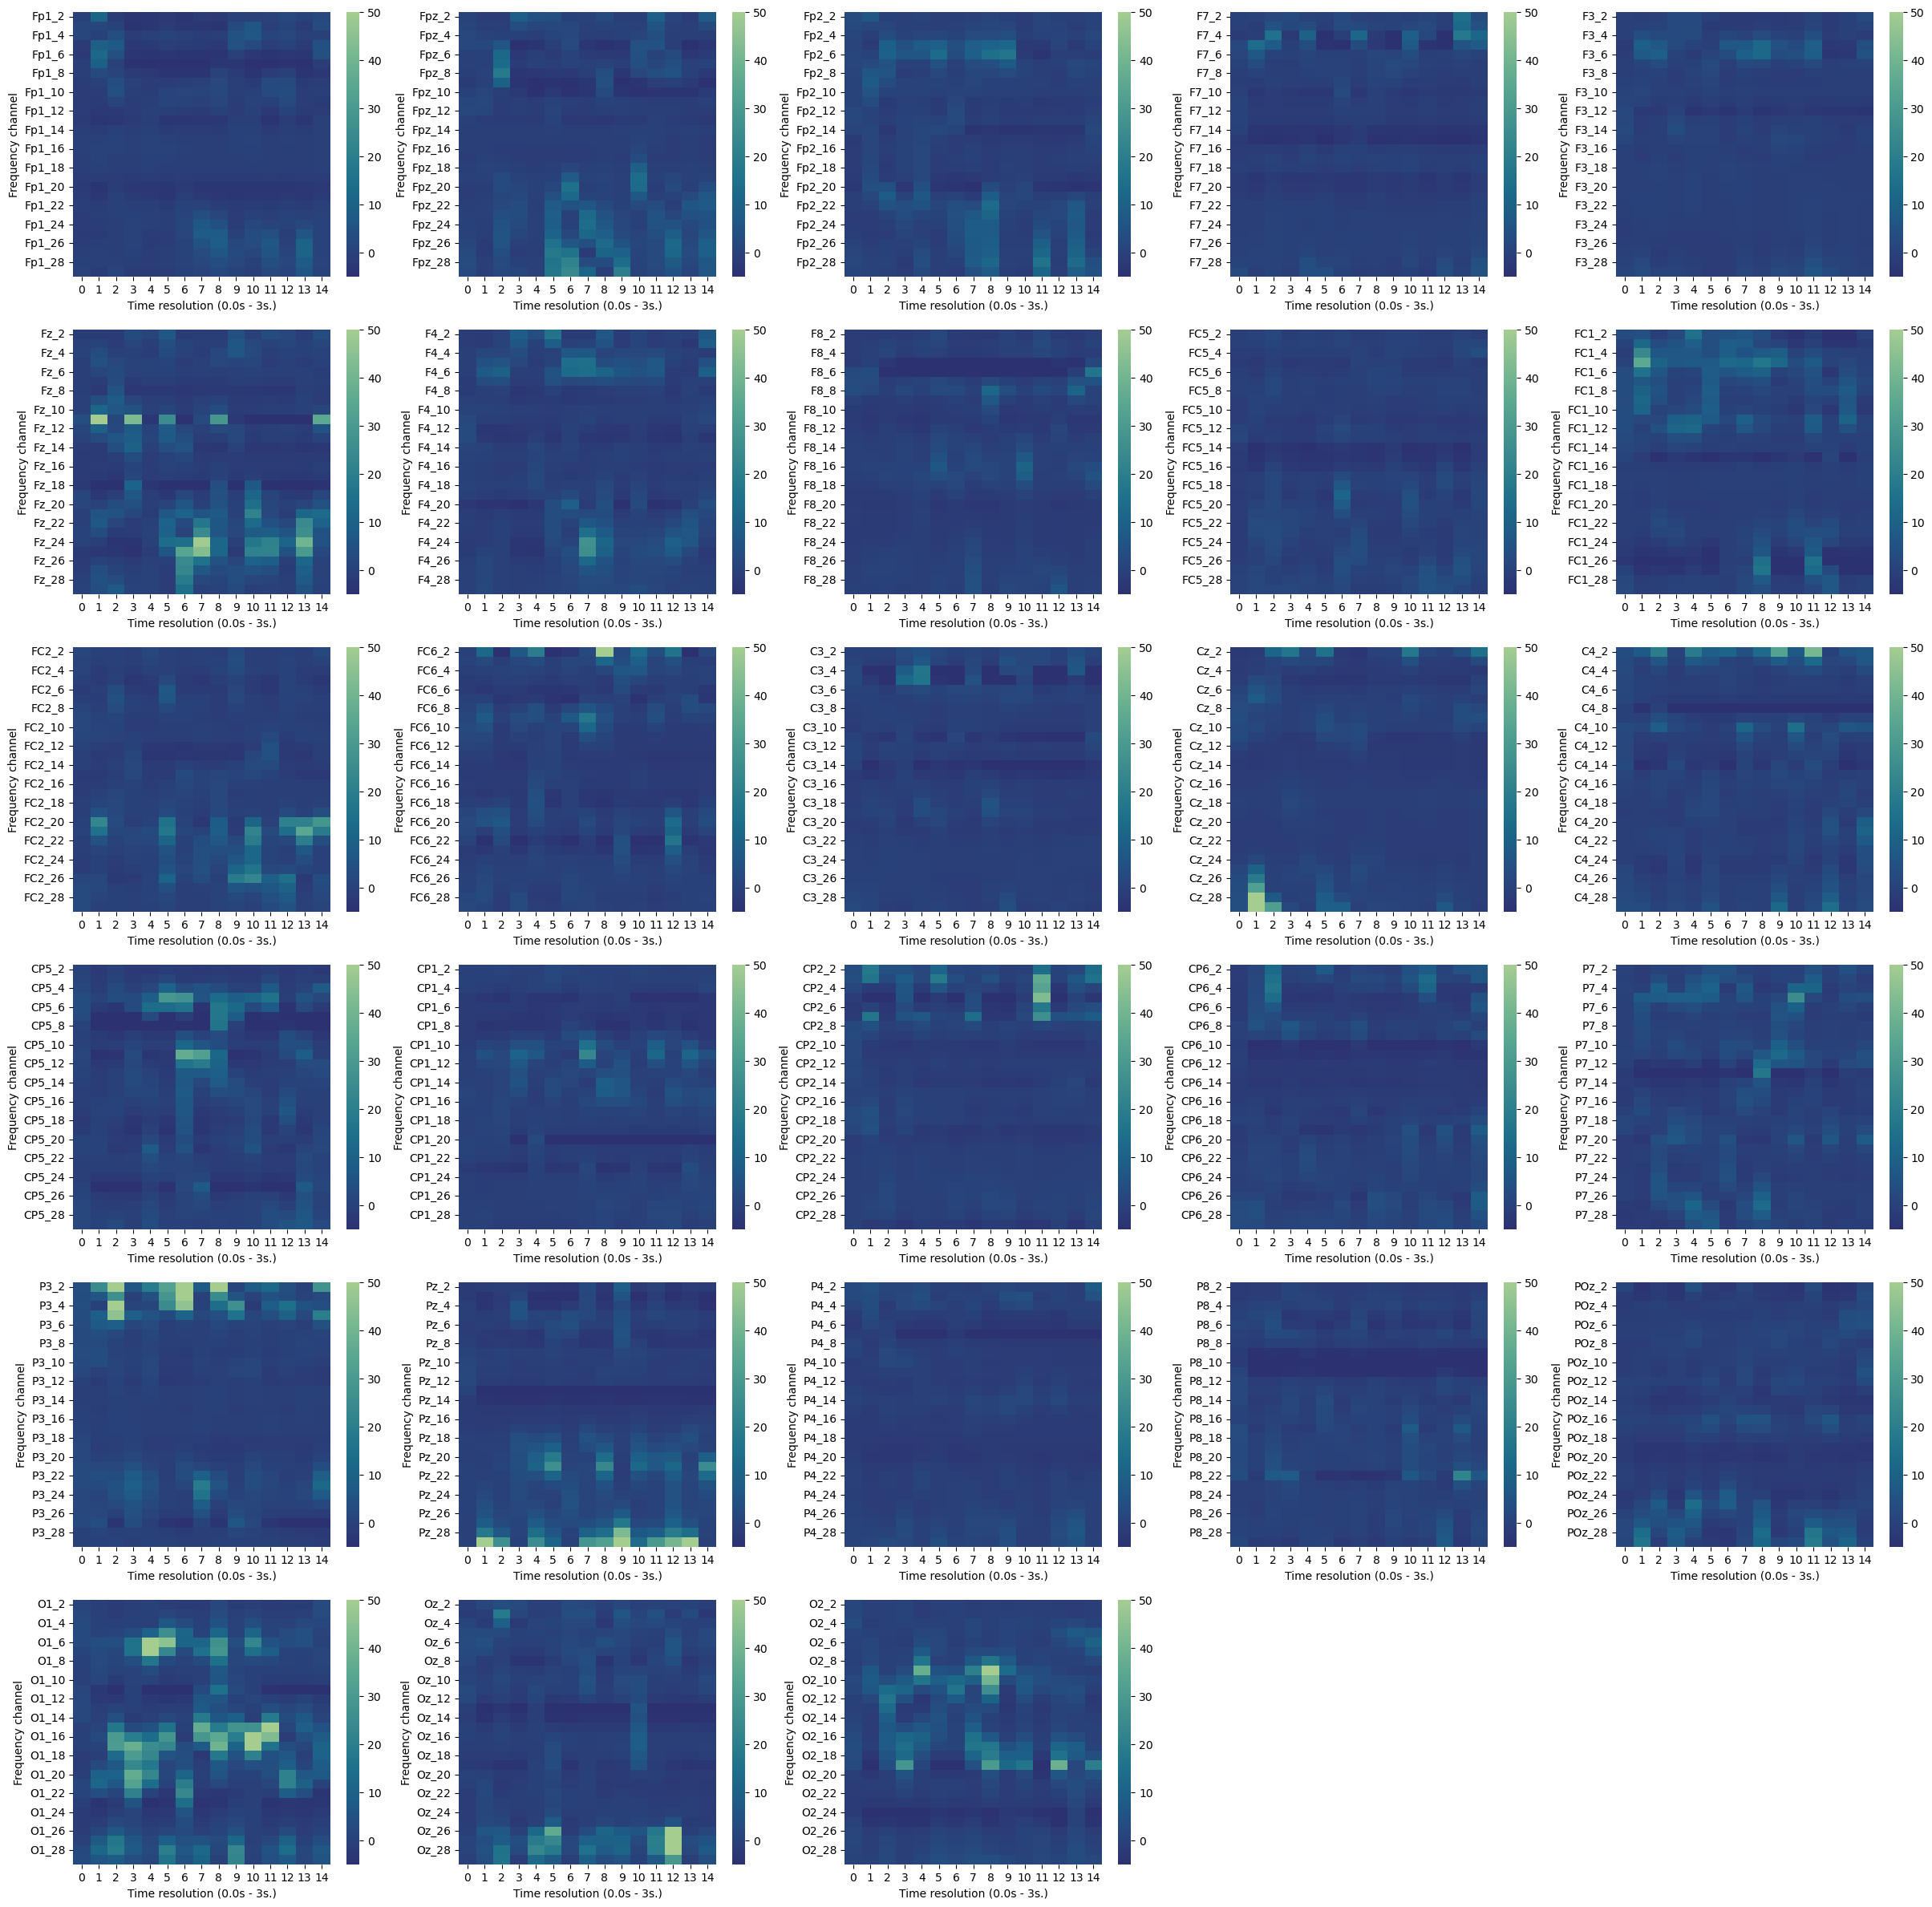

In [22]:
# loop plots for tensor data
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30, 30))

for i in range(28):
    ax = plt.subplot(6, 5, i + 1)
    sns.heatmap(new_df.iloc[:,28*i:28*(i+1)].astype(float).T, cmap='crest_r', vmin=-5, vmax=50)
    ax.set_xlabel("Time resolution (0.0s - 3s.)")
    ax.set_ylabel("Frequency channel")
plt.savefig("../img/row0_heatmap_by_sensor.svg")
plt.show()

#fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6))
#for ax, dat in zip(axs.ravel(), data):

**different channel, same frequency**

/tmp/ipykernel_230059/2236593426.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 5, i + 1)


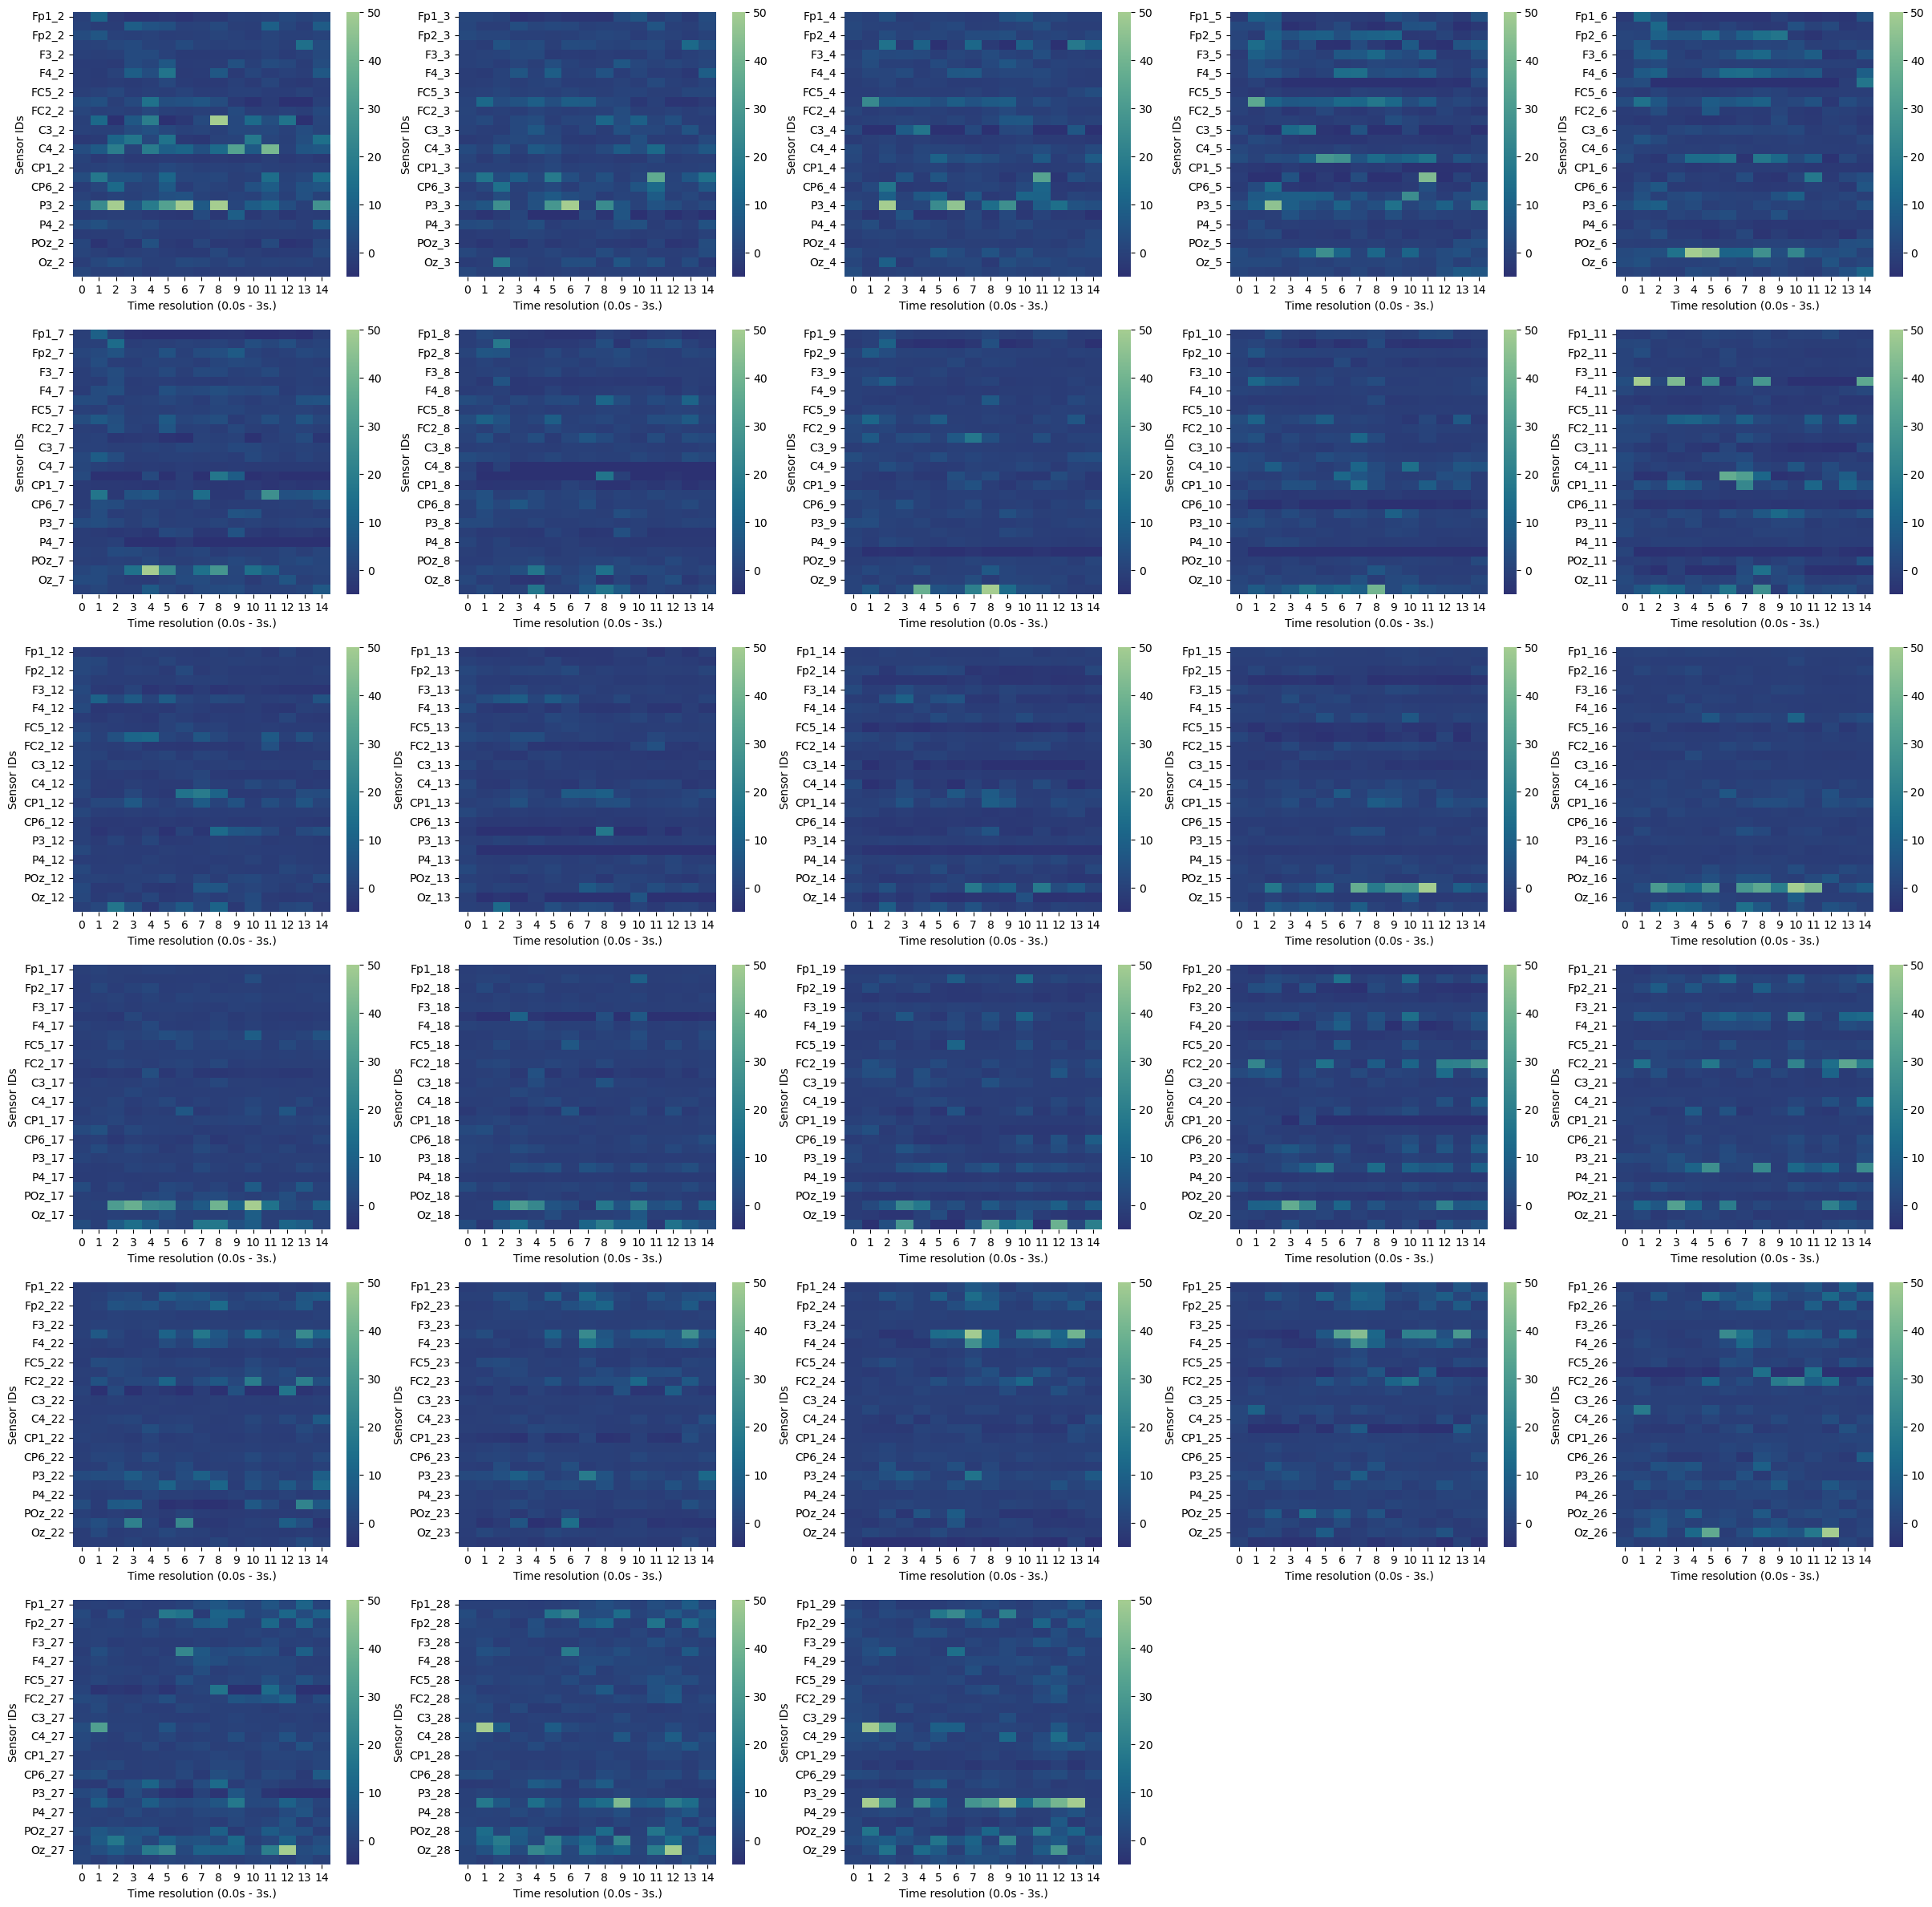

In [23]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30, 30))

for i in range(28):
    ax = plt.subplot(6, 5, i + 1)
    sns.heatmap(new_df.iloc[:,i::28].astype(float).T, cmap='crest_r', vmin=-5, vmax=50)
    ax.set_xlabel("Time resolution (0.0s - 3s.)")
    ax.set_ylabel("Sensor IDs")
plt.savefig("../img/row0_heatmap_by_frequency.svg")
plt.show()

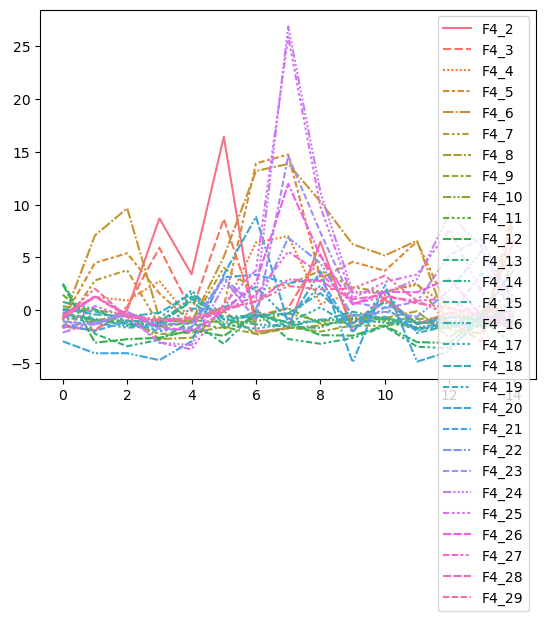

In [27]:
# alternatively, try line plot
p = sns.lineplot(new_df.iloc[:,28*6:28*7].astype(float))

## Visualisation for one subject: Memorable (label 1)

In [24]:
# select the memorable clip with participant 19
row = 7
new_df = df2.iloc[row, 0:15].reset_index(drop=True)
col_list = []
for i in range(1,(len(df2.columns)-3)//15):
    new_df = pd.concat([new_df, df2.iloc[row,i*15:(i+1)*15].reset_index(drop=True)], axis=1)
    col_list.append(df2.columns[i*15][:-2])

In [25]:
new_df.columns = ['Fp1_2'] + col_list

**one sensor, all-channel**

/tmp/ipykernel_230059/3386500351.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 5, i + 1)


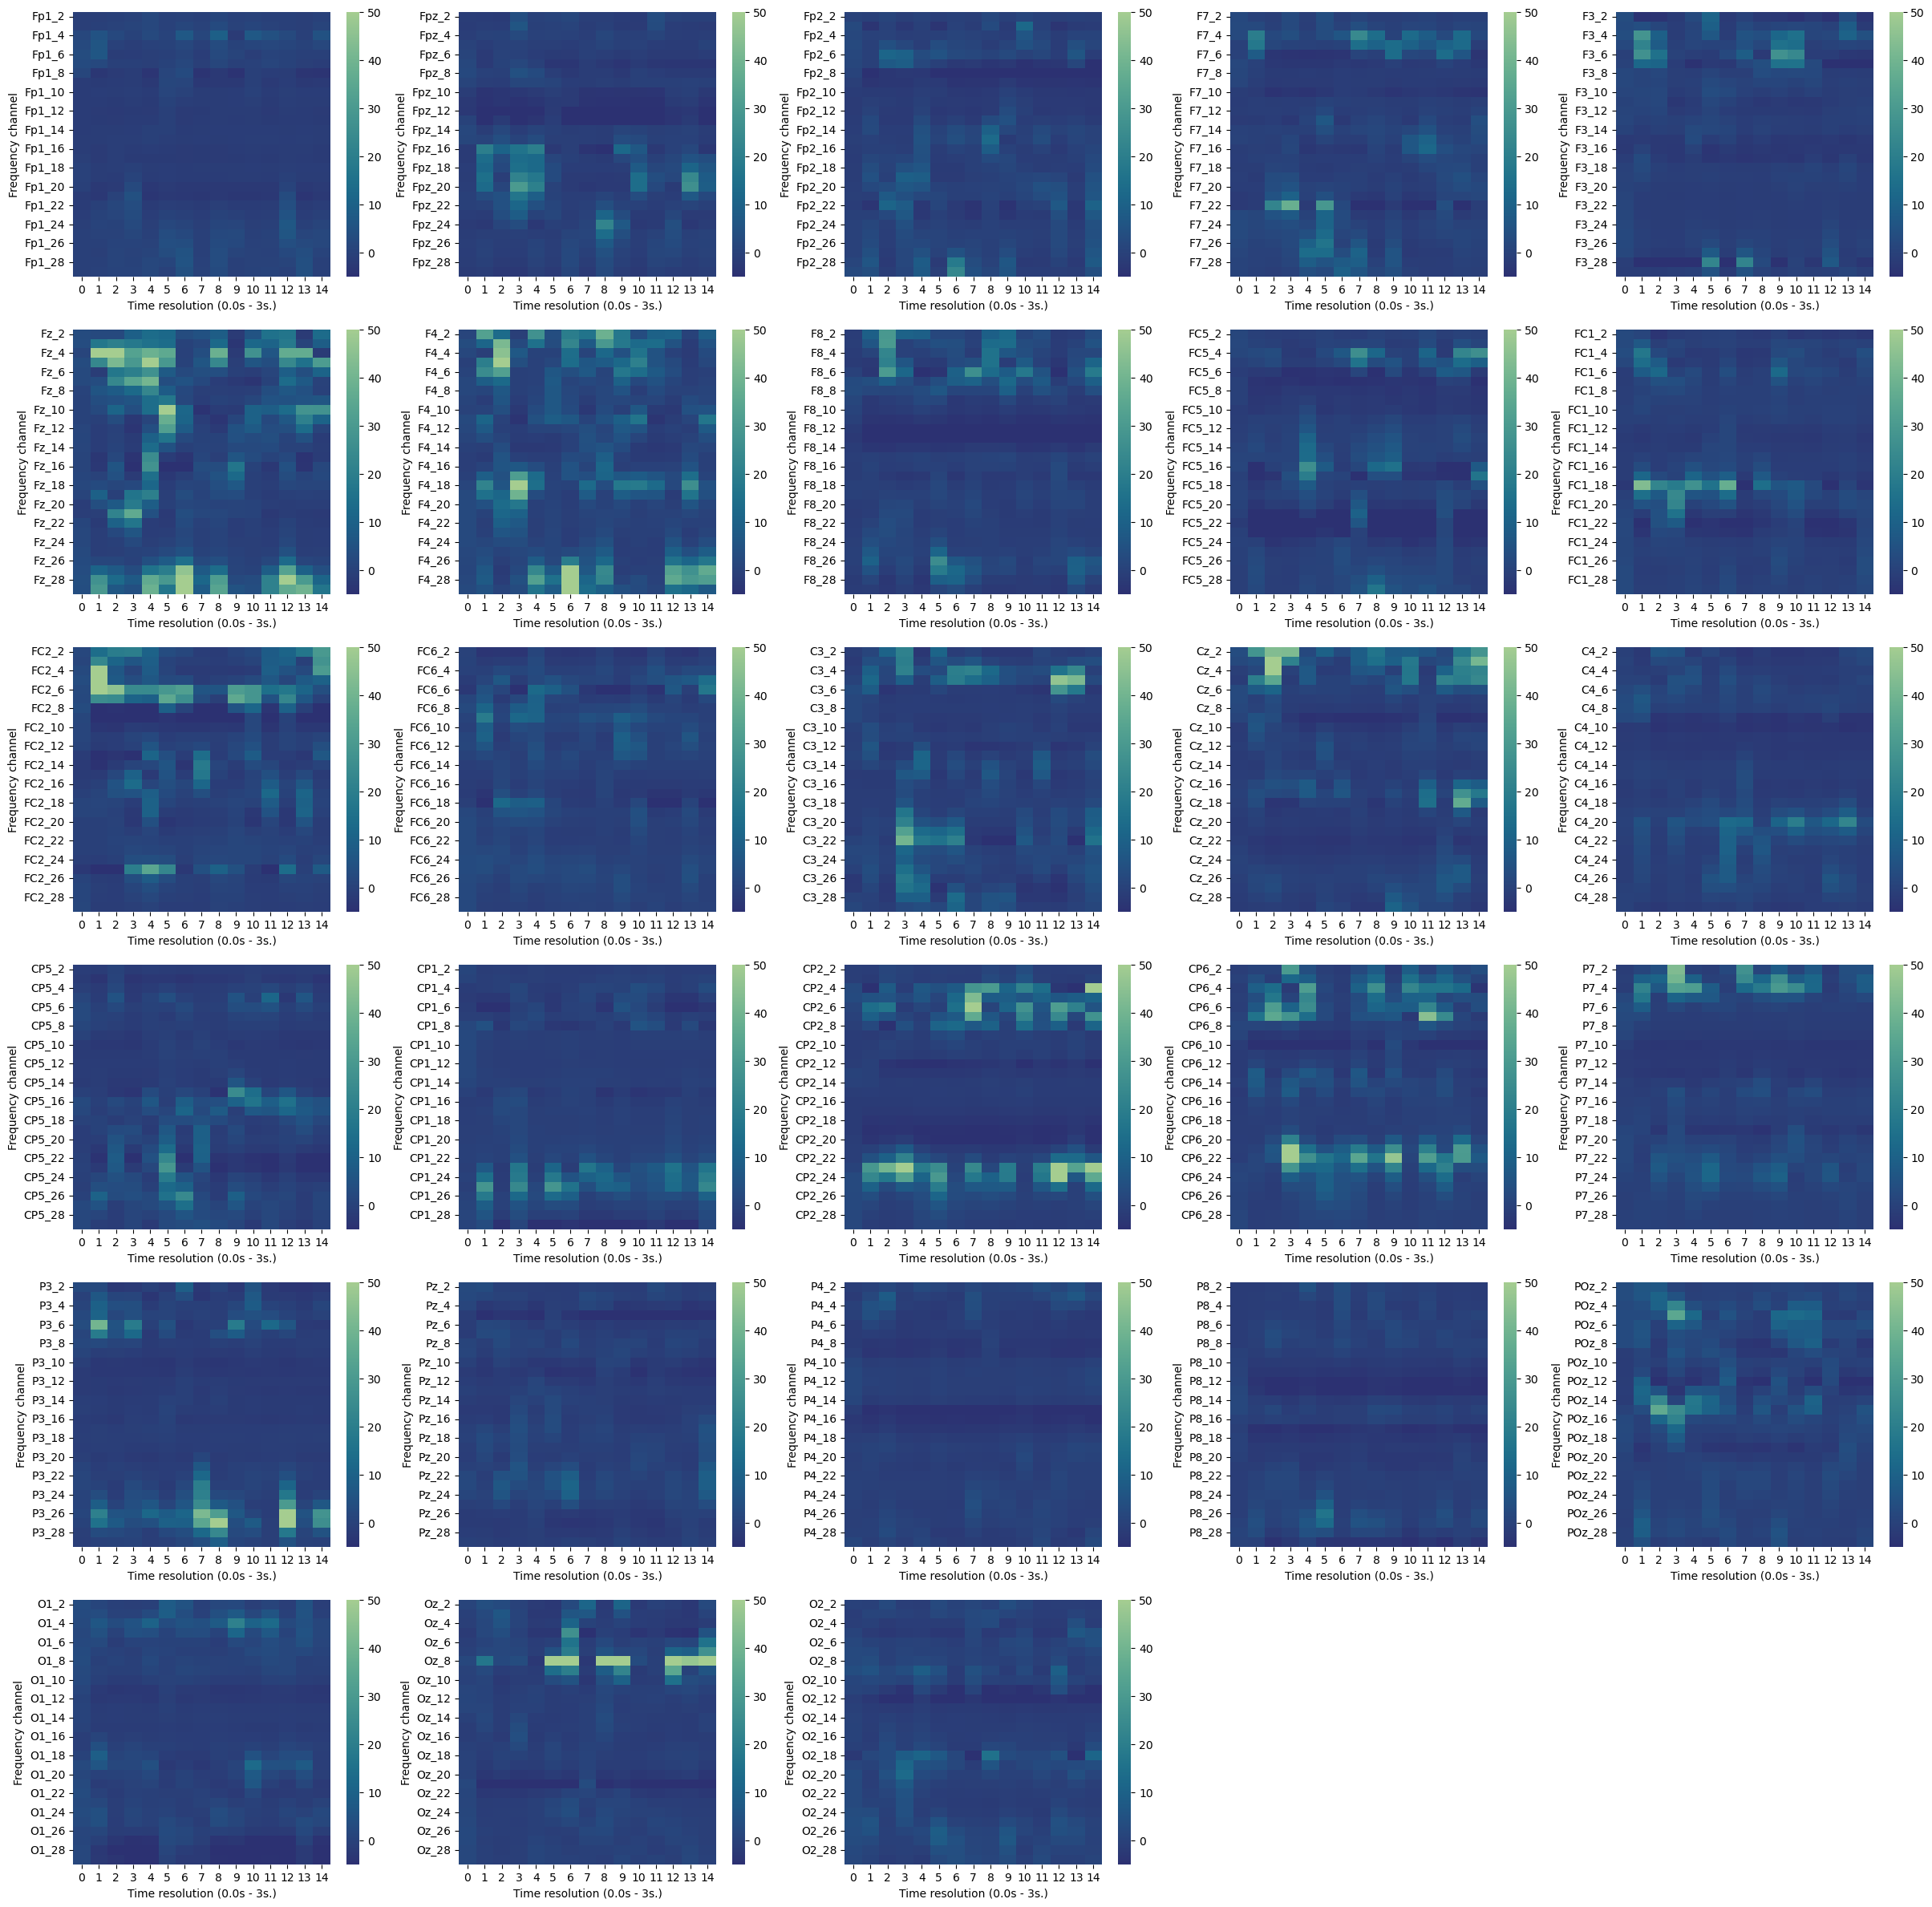

In [26]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30, 30))

for i in range(28):
    ax = plt.subplot(6, 5, i + 1)
    sns.heatmap(new_df.iloc[:,28*i:28*(i+1)].astype(float).T, cmap='crest_r', vmin=-5, vmax=50)
    ax.set_xlabel("Time resolution (0.0s - 3s.)")
    ax.set_ylabel("Frequency channel")
plt.savefig('../img/row' + str(row) + '_heatmap_by_sensor.svg')
plt.show()

#fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6))
#for ax, dat in zip(axs.ravel(), data):

**different channel, same frequency**

/tmp/ipykernel_230059/2577897215.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 5, i + 1)


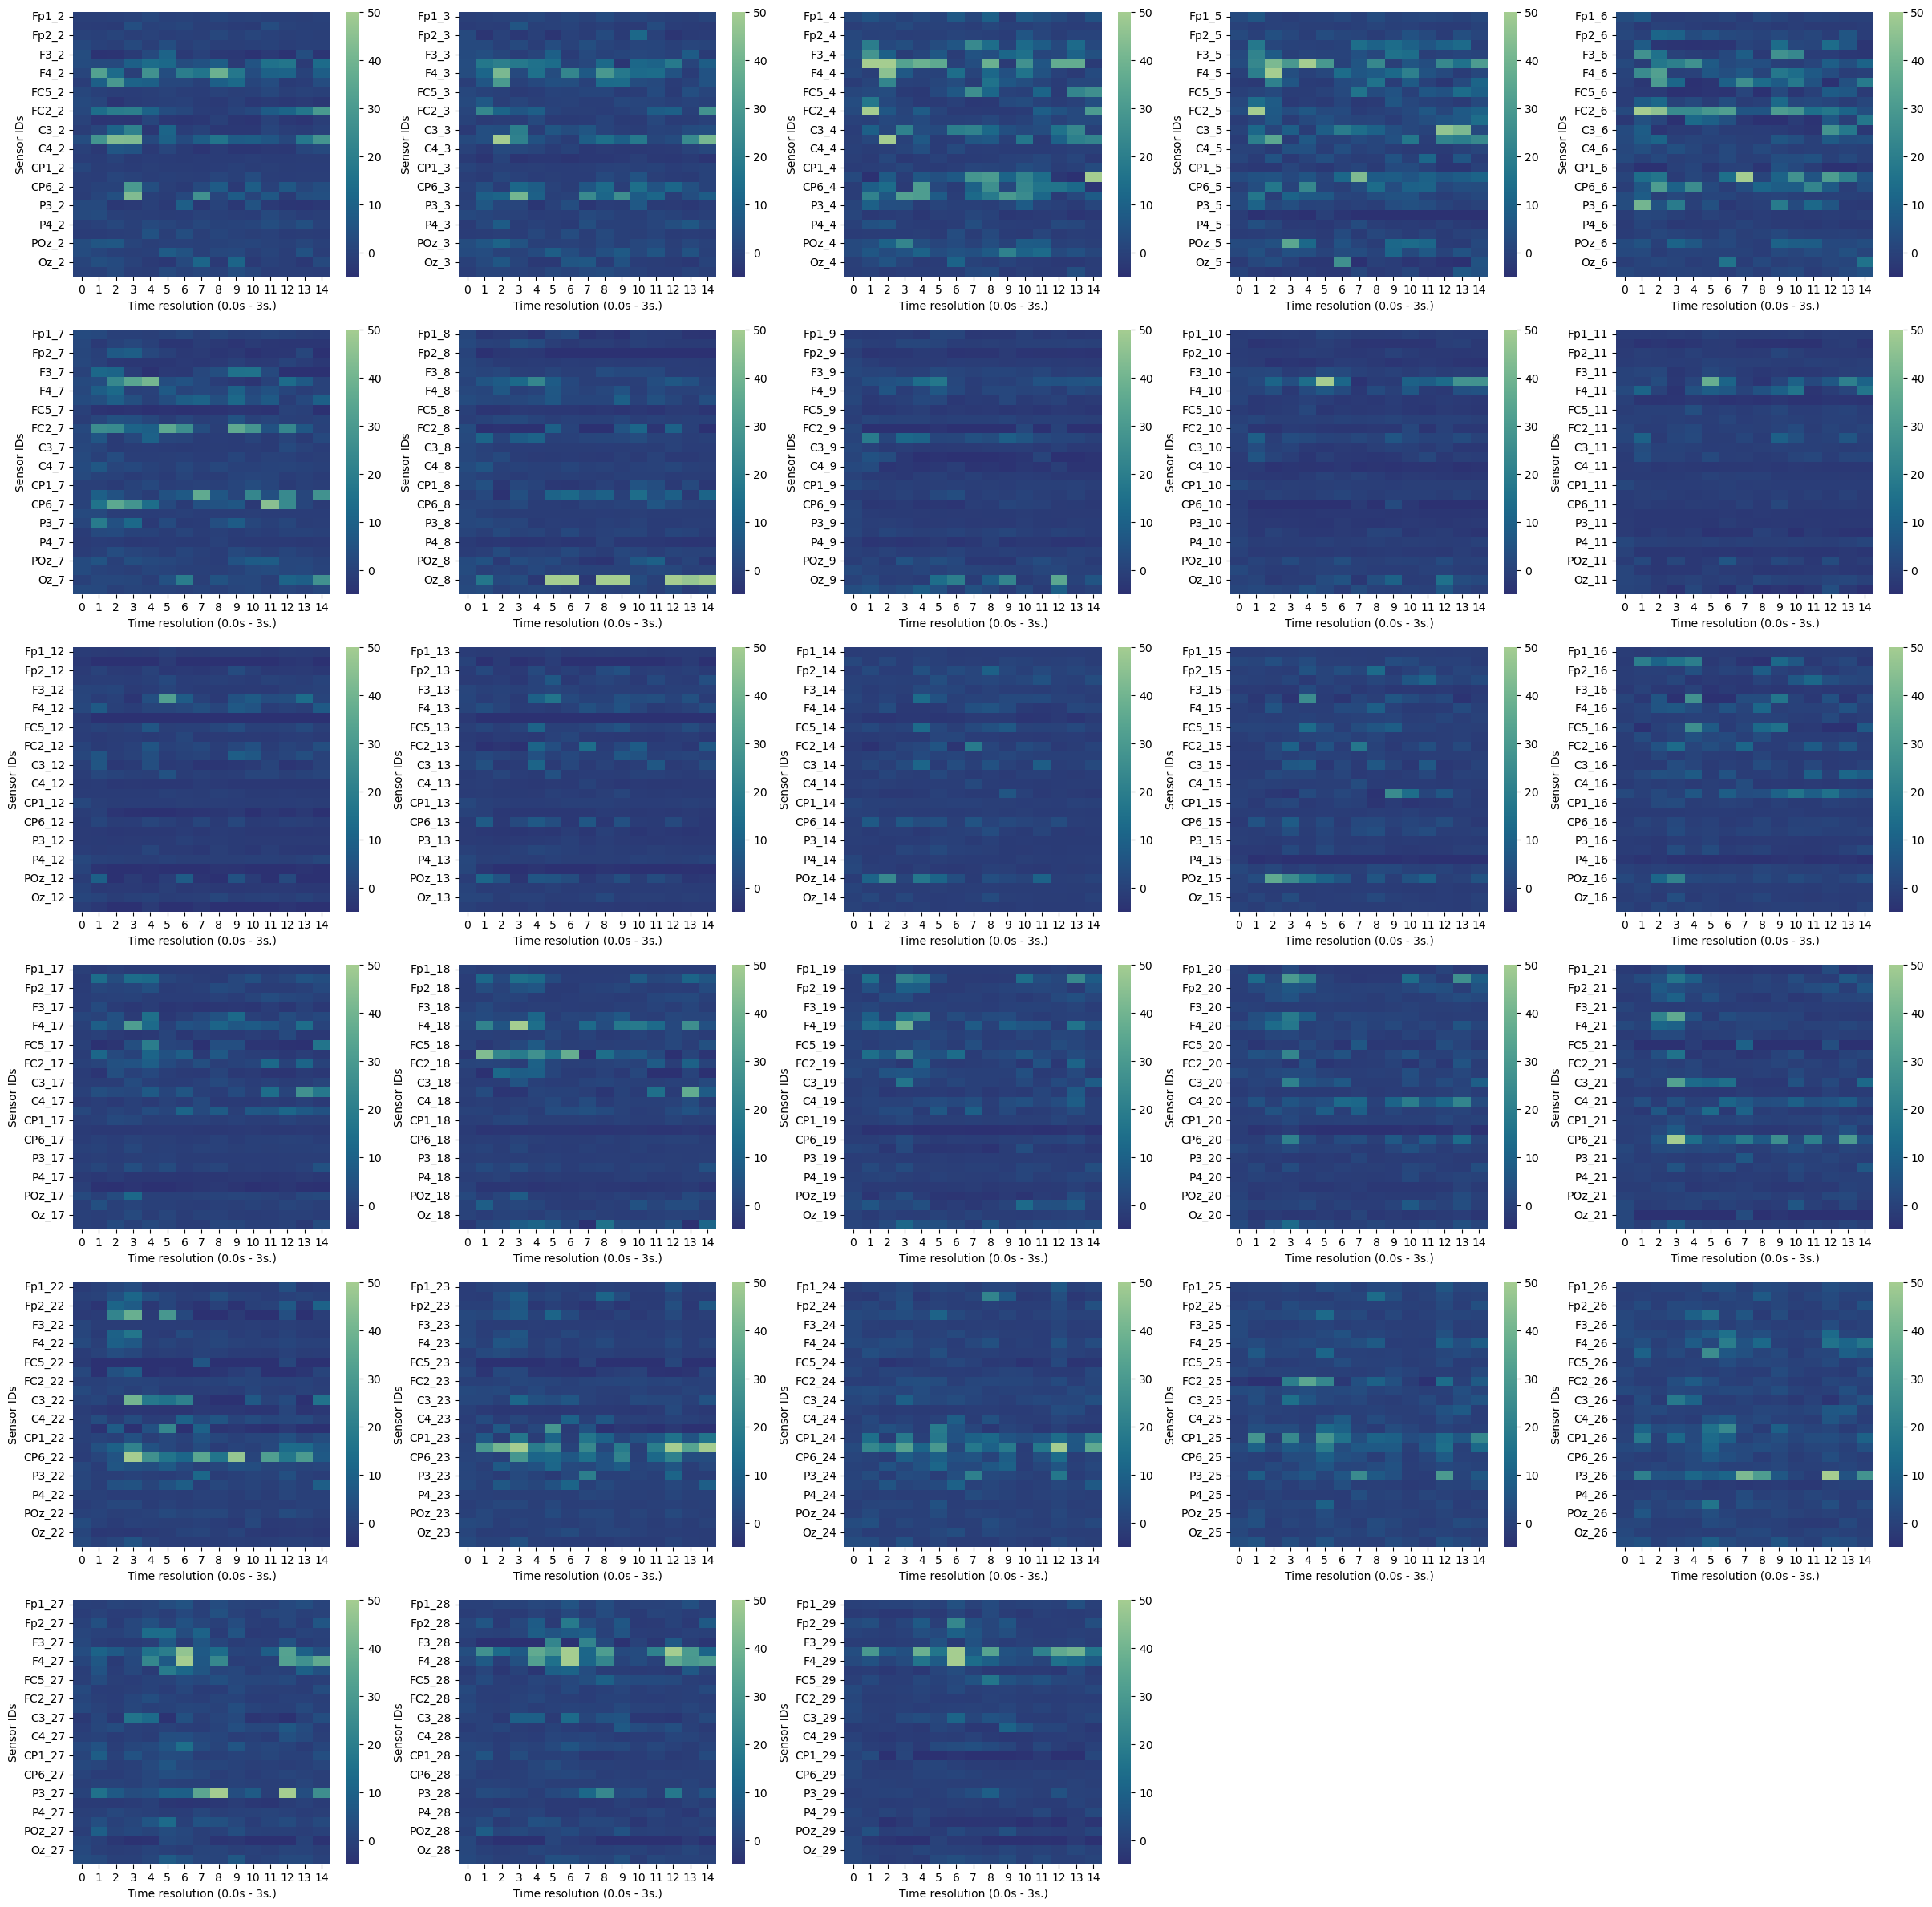

In [27]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30, 30))

for i in range(28):
    ax = plt.subplot(6, 5, i + 1)
    sns.heatmap(new_df.iloc[:,i::28].astype(float).T, cmap='crest_r', vmin=-5, vmax=50)
    ax.set_xlabel("Time resolution (0.0s - 3s.)")
    ax.set_ylabel("Sensor IDs")
plt.savefig('../img/row' + str(row) + '_heatmap_by_frequency.svg')
plt.show()

## Preprocessing I: Statistics through time

can skip to the training part if processed it already

In [ ]:
# create feature from time-series data
# create the new DataFrame with subject_id and filename
df = df2[['subject', 'filename']]
column_list = []
column_list2 = []
# mean, std, median, max, min, kurtosis index, Q1, Q2, Q3
stats_list = ['mean', 'std', 'median', 'max', 'min', 'kurtosis', 'Q1', 'Q2', 'Q3']

for i in range((len(df2.columns)-3)//15):
    # append statistic columns for each channel (t_0 - t_end) to the new DataFrame
    # mean, std, meadian, max, min, kurtosis index, Q1, Q2, Q3
    df = pd.concat([df,
           df2.iloc[:,15*(i):15*(i+1)].mean(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].std(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].median(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].max(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].min(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].kurtosis(axis=1),
           df2.iloc[:,15*(i):15*(i+1)].quantile(q=0.25, axis=1),
           df2.iloc[:,15*(i):15*(i+1)].quantile(q=0.5, axis=1),
           df2.iloc[:,15*(i):15*(i+1)].quantile(q=0.75, axis=1),
           ], axis=1).copy()
    # create a column_list, e.g. `Fp_2_mean` `Fp_2_Q1` 
    col_name = df2.columns[i*15][:-2]
    column_list.append(col_name)
    for name in stats_list:
        column_list2.append(col_name+'_' + name)

column_header = ['subject', 'filename']
column_header += column_list2

# assign column name to `df`
df.columns = column_header
df['label'] = df2['LABEL'].copy()
# drop missing data
df.dropna(inplace=True)
# transform clip name to id
ord = OrdinalEncoder()
df['filename_id'] = ord.fit_transform(df[['filename']])
# TODO save the processed dataframe to file
df.to_csv('../data/EEG_task3/ERSP_data_group2_stats.csv')
# delete dataframe, save memory
del df2

In [ ]:
# check if the data label is balance
df['label'].value_counts()

## Preprocessing II: Collecting stats for each time

can skip to the training part if processed it already

In [35]:
# transfor filename to file_id
ord = OrdinalEncoder()
df2['file_id'] = ord.fit_transform(df2[['filename']])

In [37]:
subject_id = df2['subject'].unique()[0]
subject_df = df2[df2['subject']==subject_id]
subject_df2 = None
sub_vid_df2 = None
print(subject_id)

4


In [38]:
# preprocessing code for deriving statistical data into matrix table
# data from the same frequency, but different columns will be calculated together
for row in range(subject_df.shape[0]):
    
    # define subject-video pair DF
    sub_vid_df = subject_df.iloc[row,0:15].reset_index(drop=True)
    # select column range to process, do not include last 3 columns
    for i in range(1,(len(subject_df.columns)-3)//15):
        sub_vid_df = pd.concat([sub_vid_df, subject_df.iloc[row,i*15:(i+1)*15].reset_index(drop=True)], axis=1)
    # for 28 frequencies, do for each frequency
    for i in range(28):
        col_name = sub_vid_df.iloc[:,i::28].astype(float).T.describe().iloc[1:,:].T.columns.values
        sub_df = pd.concat([sub_vid_df.iloc[:,i::28].astype(float).T.describe().iloc[1:,:].T, 
                        sub_vid_df.iloc[:,i::28].astype(float).T.kurtosis()],
                       axis=1)
        # add a new column 'k'
        col_name = np.append(col_name, 'k')
        # rename sub_df's columns
        sub_df.columns = col_name
        # rename sub_df's columns again, add prefix 'c(freq)_'
        sub_df.columns =  ['c'+ str(i+2) + '_'] + sub_df.columns
        if i==0:
            sub_vid_df2 = sub_df
        else:
            sub_vid_df2 = pd.concat([sub_vid_df2, sub_df], axis=1)
    # assign new DF
    sub_vid_df3 = sub_vid_df2
    # add file_id to the new DF
    sub_vid_df3['file_id'] = np.repeat(subject_df['file_id'].iloc[row], sub_vid_df3.shape[0])
    # add label to the new DF
    sub_vid_df3['label'] = np.repeat(subject_df['LABEL'].iloc[row], sub_vid_df3.shape[0])
    # add time to the new DF by resetting the indexes
    sub_vid_df3.reset_index(names='time', inplace=True)
    # export the result
    sub_vid_df3.to_csv('../data/EEG_task3/pre_train/sub_vid_'+str(row)+'.csv')
    if row==0:
        subject_df2 = sub_vid_df3
    else:
        subject_df2 = pd.concat([subject_df2, sub_vid_df3], ignore_index=True, axis=0)
    print("row {}/{} processed...".format(row+1, subject_df.shape[0]))
    # debug part
    #if row==1:
    #    break

row 1/698 processed...
row 2/698 processed...
row 3/698 processed...
row 4/698 processed...
row 5/698 processed...
row 6/698 processed...
row 7/698 processed...
row 8/698 processed...
row 9/698 processed...
row 10/698 processed...
row 11/698 processed...
row 12/698 processed...
row 13/698 processed...
row 14/698 processed...
row 15/698 processed...
row 16/698 processed...
row 17/698 processed...
row 18/698 processed...
row 19/698 processed...
row 20/698 processed...
row 21/698 processed...
row 22/698 processed...
row 23/698 processed...
row 24/698 processed...
row 25/698 processed...
row 26/698 processed...
row 27/698 processed...
row 28/698 processed...
row 29/698 processed...
row 30/698 processed...
row 31/698 processed...
row 32/698 processed...
row 33/698 processed...
row 34/698 processed...
row 35/698 processed...
row 36/698 processed...
row 37/698 processed...
row 38/698 processed...
row 39/698 processed...
row 40/698 processed...
row 41/698 processed...
row 42/698 processed...
r

row 334/698 processed...
row 335/698 processed...
row 336/698 processed...
row 337/698 processed...
row 338/698 processed...
row 339/698 processed...
row 340/698 processed...
row 341/698 processed...
row 342/698 processed...
row 343/698 processed...
row 344/698 processed...
row 345/698 processed...
row 346/698 processed...
row 347/698 processed...
row 348/698 processed...
row 349/698 processed...
row 350/698 processed...
row 351/698 processed...
row 352/698 processed...
row 353/698 processed...
row 354/698 processed...
row 355/698 processed...
row 356/698 processed...
row 357/698 processed...
row 358/698 processed...
row 359/698 processed...
row 360/698 processed...
row 361/698 processed...
row 362/698 processed...
row 363/698 processed...
row 364/698 processed...
row 365/698 processed...
row 366/698 processed...
row 367/698 processed...
row 368/698 processed...
row 369/698 processed...
row 370/698 processed...
row 371/698 processed...
row 372/698 processed...
row 373/698 processed...


row 662/698 processed...
row 663/698 processed...
row 664/698 processed...
row 665/698 processed...
row 666/698 processed...
row 667/698 processed...
row 668/698 processed...
row 669/698 processed...
row 670/698 processed...
row 671/698 processed...
row 672/698 processed...
row 673/698 processed...
row 674/698 processed...
row 675/698 processed...
row 676/698 processed...
row 677/698 processed...
row 678/698 processed...
row 679/698 processed...
row 680/698 processed...
row 681/698 processed...
row 682/698 processed...
row 683/698 processed...
row 684/698 processed...
row 685/698 processed...
row 686/698 processed...
row 687/698 processed...
row 688/698 processed...
row 689/698 processed...
row 690/698 processed...
row 691/698 processed...
row 692/698 processed...
row 693/698 processed...
row 694/698 processed...
row 695/698 processed...
row 696/698 processed...
row 697/698 processed...
row 698/698 processed...


In [39]:
# export the result, again, big file
subject_df2.to_csv('../data/EEG_task3/ERSP2_preRdForest_subject' + str(subject_id) + '.csv')